# **Data Preparation**

### Packages installation

In [15]:
!pip install kagglehub
!pip install imagehash
!pip install tensorflow
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install tqdm
print("done installing packages")

done installing packages


### imports

In [16]:
import os
import kagglehub
import random
from PIL import Image
import imagehash
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tqdm import tqdm 
print("done importing packages")


done importing packages


### Dataset path

In [17]:
if 'COLAB_GPU' in os.environ:
    dataset_folder = kagglehub.dataset_download('hussainghoraba/emotions-dataset')
    DATASET_PATH = os.path.join(dataset_folder, 'Dataset')
elif 'KAGGLE_URL_BASE' in os.environ:
    DATASET_PATH = '/kaggle/input/emotions-dataset/Dataset'
elif 'VSCODE_PID' in os.environ:
    DATASET_PATH = './Dataset'
else:
    raise Exception('Unknown environment')

print("done setting up dataset path")

done setting up dataset path


### Set random seed & some global variables

In [18]:
RANDOM_SEED = 42
TAREGT_SIZE = (512, 512)
random.seed(RANDOM_SEED)

print("done setting up random seed")

done setting up random seed


### Load dataset into memory without dups, and with correct size

Total images in dataset: 2125


Loading images into memory...: 100%|██████████| 2125/2125 [00:27<00:00, 77.62it/s]


Duplicate images found: ./Dataset/Angry/ANGRY_03_0122.png and ./Dataset/Angry/A_5_0092.png


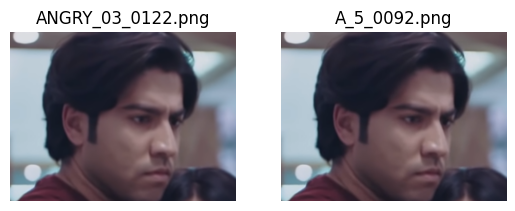

Duplicate images found: ./Dataset/Angry/ANGRY_02_0058.png and ./Dataset/Angry/ANGRY_02_0027.png


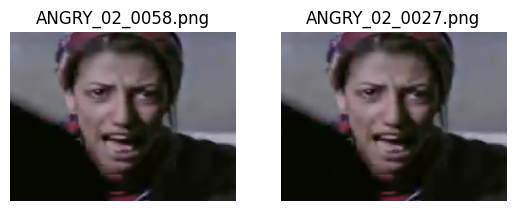

done loading images


In [19]:
total_images_count = sum(len(files) for _, _, files in os.walk(DATASET_PATH))
print(f"Total images in dataset: {total_images_count}")
data = []
dups_pairs = set()
with tqdm(total=total_images_count, desc="Loading images into memory...") as pbar:
    for subfolder in os.listdir(DATASET_PATH):
        subfolder_path = os.path.join(DATASET_PATH, subfolder)
        subfolder_hashes = {}
        for img_file in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_file)
            with Image.open(img_path) as img:
                img = img.convert("RGB").resize(TAREGT_SIZE)
                img_arr = np.array(img)
                img_hash = imagehash.phash(img)
            if img_hash not in subfolder_hashes.keys():
                data.append({"img_path": img_path, "label": subfolder, "img_arr": img_arr})
                # key : hash, value : img_path
                subfolder_hashes[img_hash] = img_path
            else:
                existing_duplicate = subfolder_hashes[img_hash]
                dups_pairs.add((img_path, existing_duplicate))
            pbar.update(1)
        
df = pd.DataFrame(data)
# shuffle the dataframe
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# display dups
for dup_pair in dups_pairs:
    print(f"Duplicate images found: {dup_pair[0]} and {dup_pair[1]}")
    img1 = Image.open(dup_pair[0])
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title(os.path.basename(dup_pair[0]))
    plt.axis('off')
    img2 = Image.open(dup_pair[1])
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title(os.path.basename(dup_pair[1]))
    plt.axis('off')
    plt.show()
print("done loading images")

### Make all classes have the same number of images

In [20]:
print(f"Before balancing: ")
print(df['label'].value_counts())

min_samples = df['label'].value_counts().min()
df = df.groupby('label', group_keys=False)[df.columns].apply(lambda x: x.sample(n=min_samples, random_state=RANDOM_SEED)).reset_index(drop=True)


print(f"\nAfter balancing: ")
print(df['label'].value_counts())

print("done balancing dataset")

Before balancing: 
label
Angry      652
Happy      619
Sad        555
Neutral    297
Name: count, dtype: int64

After balancing: 
label
Angry      297
Happy      297
Neutral    297
Sad        297
Name: count, dtype: int64
done balancing dataset


### Train/Test/Val split

In [21]:
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

train_df, temp_df = train_test_split(df, test_size=(1 - train_ratio), stratify=df['label'], random_state=RANDOM_SEED)
val_df, test_df = train_test_split(temp_df, test_size=(test_ratio / (test_ratio + val_ratio)), stratify=temp_df['label'], random_state=RANDOM_SEED)

# Print the sizes of each split
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

print("done splitting dataset into train, val, test")

Training set size: 831
Validation set size: 238
Test set size: 119
done splitting dataset into train, val, test


# **Model 1**

In [22]:
# import numpy as np
# import matplotlib.pyplot as plt
# from PIL import Image
# import requests
# from io import BytesIO

# Define the ConvLayer class
class ConvLayer:
    def __init__(self, filter_size=3, num_filters=5, filter_weights=None):
        """
        Initialize a convolutional layer with either random or predefined filter weights.

        Parameters:
        - filter_size: Size of the square filters (default: 3 for 3x3)
        - num_filters: Number of filters to use (default: 5)
        - filter_weights: Optional predefined filter weights as a 4D numpy array
                        of shape (num_filters, filter_size, filter_size, 3) for RGB images
        """
        self.filter_size = filter_size
        self.num_filters = num_filters

        if filter_weights is not None:
            # Initialize with predefined weights
            self.filters = filter_weights
        else:
            # Initialize with random weights
            # For RGB images, we need filters of shape (num_filters, filter_size, filter_size, 3)
            self.filters = np.random.randn(num_filters, filter_size, filter_size, 3) * 0.1

    def forward(self, input_image):
        """
        Perform forward pass of convolution.

        Parameters:
        - input_image: Input image of shape (height, width, channels)

        Returns:
        - output: Convolved feature maps
        """
        # Get dimensions
        input_height, input_width, input_channels = input_image.shape

        # Calculate output dimensions
        output_height = input_height - self.filter_size + 1
        output_width = input_width - self.filter_size + 1

        # Initialize output volume
        output = np.zeros((output_height, output_width, self.num_filters))

        # Perform convolution
        for f in range(self.num_filters):
            for h in range(output_height):
                for w in range(output_width):
                    # Extract the current patch from the input image
                    input_patch = input_image[h:h+self.filter_size, w:w+self.filter_size, :]

                    # Manual element-wise multiplication and summation
                    sum_value = 0.0
                    for i in range(self.filter_size):
                        for j in range(self.filter_size):
                            for c in range(input_channels):
                                sum_value += input_patch[i, j, c] * self.filters[f, i, j, c]
                    
                    output[h, w, f] = sum_value

        return output

# Define the filters from the image
def create_filter_3d(filter_2d):
    """Convert a 2D filter to a 3D filter by applying it to all channels."""
    filter_3d = np.zeros((3, 3, 3))
    for c in range(3):  # Each channel
        filter_3d[:, :, c] = filter_2d
    return filter_3d

# Define the 5 filters from the image
filter_a = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

filter_b = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
])

filter_c = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

filter_d = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
])

filter_e = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

# Convert 2D filters to 3D
filter_a_3d = create_filter_3d(filter_a)
filter_b_3d = create_filter_3d(filter_b)
filter_c_3d = create_filter_3d(filter_c)
filter_d_3d = create_filter_3d(filter_d)
filter_e_3d = create_filter_3d(filter_e)

# Stack the filters into a single 4D array (num_filters, height, width, channels)
all_filters = np.stack([filter_a_3d, filter_b_3d, filter_c_3d, filter_d_3d, filter_e_3d])

# # Function to load and preprocess an image
# def load_image(url=None, path=None, target_size=(512, 512)):
#     """Load an image from URL or local path and preprocess it."""
#     if url:
#         response = requests.get(url)
#         img = Image.open(BytesIO(response.content))
#     elif path:
#         img = Image.open(path)
#     else:
#         # Create a sample image if no source is provided
#         img = Image.new('RGB', target_size, color=(73, 109, 137))

#     # Resize the image
#     img = img.resize(target_size)

#     # Convert to numpy array
#     img_array = np.array(img) / 255.0  # Normalize to [0, 1]

#     return img_array

# # Test with a sample image (you can replace this URL with your own image)
# # Using a sample image URL - replace with your own image or add code to load a local file
# sample_image_url = "https://images.wallpapersden.com/image/download/cat-green-eyed-muzzle_aWhnZ5SZmpqtpaSklGpmZ61qZmc.jpg"
# try:
#     img = load_image(url=sample_image_url)
# except:
#     # If the URL doesn't work, create a simple test image
#     img = np.zeros((512, 512, 3))
#     # Add some shapes for testing
#     img[100:400, 100:400, 0] = 1.0  # Red square
#     img[200:300, 200:300, 1] = 1.0  # Green square inside red

# Initialize a ConvLayer with the predefined filters
conv_layer = ConvLayer(filter_size=3, num_filters=5, filter_weights=all_filters)

# # Apply convolution
# feature_maps = conv_layer.forward(img)

# # Visualize the original image and the feature maps
# plt.figure(figsize=(15, 8))

# # Original image
# plt.subplot(2, 3, 1)
# plt.imshow(img)
# plt.title('Original Image')
# plt.axis('off')

# # Feature maps
# filter_names = ['Box Filter (a)', 'Identity Filter (b)', 'Sobel X (c)', 'Sobel Y (d)', 'Sharpening (e)']

# for i in range(5):
#     plt.subplot(2, 3, i+2)
#     # Normalize the feature map for better visualization
#     feature_map = feature_maps[:, :, i]
#     feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min() + 1e-8)
#     plt.imshow(feature_map, cmap='viridis')
#     plt.title(f'Filter {i+1}: {filter_names[i]}')
#     plt.axis('off')

# plt.tight_layout()
# plt.show()

# # Test individual filters
# print("\nTesting individual filters:")
# for i, (filter_name, filter_3d) in enumerate(zip(filter_names, [filter_a_3d, filter_b_3d, filter_c_3d, filter_d_3d, filter_e_3d])):
#     # Create a ConvLayer with a single filter
#     single_filter = np.expand_dims(filter_3d, axis=0)
#     conv_layer_single = ConvLayer(filter_size=3, num_filters=1, filter_weights=single_filter)

#     # Apply convolution
#     feature_map = conv_layer_single.forward(img)

#     print(f"Filter {i+1} ({filter_name}) applied successfully.")

print("done model 1")

done model 1


# **Model 2**

In [ ]:
# At the start of page 5 in the project description, point 1 says : build a CNN with 3 convolutional layers,
# but point 2 says we should use 5 filters, how ? we only have 3 conv layers.
# so we decided to ignore point 1 and use 5 conv layers instead of 3
num_classes = len(df['label'].unique())
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (5, 5), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(16, (7, 7), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    # 128 is OUR CHOICE for the number of neurons in the hidden layer (not specified in the project description)
    layers.Dense(128, activation='sigmoid'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

print("done building model 2")

done building model 2


Found 831 validated image filenames belonging to 4 classes.
Found 238 validated image filenames belonging to 4 classes.
images sizes passed to image data generator: (512, 512, 3)
Found 119 validated image filenames belonging to 4 classes.


/home/hosain/Desktop/DL project/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


2025-04-22 16:21:54.862222: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 532684800 exceeds 10% of free system memory.
2025-04-22 16:21:56.061100: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 532684800 exceeds 10% of free system memory.


 1/52 ━━━━━━━━━━━━━━━━━━━━ 3:15 4s/step - accuracy: 0.1875 - loss: 1.4808

2025-04-22 16:21:56.736747: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 532684800 exceeds 10% of free system memory.
2025-04-22 16:21:57.994777: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 532684800 exceeds 10% of free system memory.


 2/52 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - accuracy: 0.2031 - loss: 1.4537

2025-04-22 16:21:58.611176: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 532684800 exceeds 10% of free system memory.


52/52 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.2177 - loss: 1.4064 - val_accuracy: 0.2563 - val_loss: 1.3898
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.2399 - loss: 1.3872 - val_accuracy: 0.2479 - val_loss: 1.4095
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.2949 - loss: 1.3944 - val_accuracy: 0.3571 - val_loss: 1.3414
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.4060 - loss: 1.3177 - val_accuracy: 0.2521 - val_loss: 1.3859
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.3138 - loss: 1.3410 - val_accuracy: 0.2689 - val_loss: 1.3715
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.3811 - loss: 1.2938 - val_accuracy: 0.3403 - val_loss: 1.3841
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.4517 - loss: 1.2468 - val_accuracy: 0.3151 - val_loss: 1.4001
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.4906 - loss: 1.1967 - val_accuracy: 0.3487 - val_loss: 1.

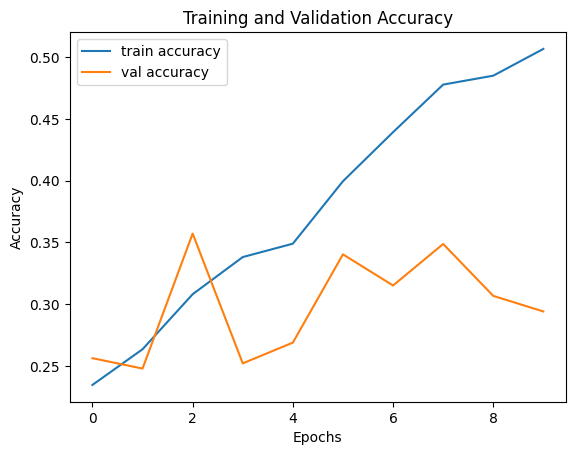

done training model 2


In [24]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 16
epochs = 10

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    target_size=TAREGT_SIZE,
    x_col='img_path',  
    y_col='label',    
    batch_size=batch_size,
    class_mode='categorical', 
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    target_size=TAREGT_SIZE,
    x_col='img_path',
    y_col='label',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
print(f"images sizes passed to image data generator: {train_gen.image_shape}")

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    target_size=TAREGT_SIZE,
    x_col='img_path',
    y_col='label',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
)

test_loss, test_acc = model.evaluate(test_gen)
print(f"Val accuracy: {history.history['val_accuracy'][-1]:.2f}")
print(f"Test accuracy: {test_acc:.2f}")


# plot the training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print("done training model 2")


In [25]:
# # Get class indices and reverse mapping
# class_indices = test_gen.class_indices
# class_labels = list(class_indices.keys())

# # Get predictions for the test set
# preds = model.predict(test_gen)
# predicted_classes = np.argmax(preds, axis=1)
# true_classes = test_gen.classes
# filenames = test_gen.filenames

# # Display 10 random images with predictions
# num_images = 10
# indices = np.random.choice(len(filenames), num_images, replace=False)

# plt.figure(figsize=(20, 10))

# for i, idx in enumerate(indices):
#     img_path = os.path.join(test_dir, filenames[idx])
#     img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
#     img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0

#     plt.subplot(2, 5, i + 1)
#     plt.imshow(img_array)
#     plt.axis('off')
#     true_label = class_labels[true_classes[idx]]
#     predicted_label = class_labels[predicted_classes[idx]]
#     title_color = "green" if true_label == predicted_label else "red"
#     plt.title(f"True: {true_label}\nPred: {predicted_label}", color=title_color)

# plt.tight_layout()
# plt.show()

print("done displaying predictions")


done displaying predictions
